In [94]:
### Task 3
# Conduct a similar analysis for the returns on (i) a G10 carry trade strategy, (ii) a carry
# trade strategy that includes emerging market currencies, (iii) a bond strategy that is
# long duration, and (iv) a bond strategy that is long inflation-protected bonds and short
# nominal bonds. You are not required to develop these strategies on your own; it is
# sufficient if you obtain the returns on indices tracking them.

# Load Packages

In [120]:
#### Import required Packages ####
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import scipy as sp
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error # to calculate the MSE
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

from statsmodels.graphics.tsaplots import plot_acf # To produce ACF plots
from statsmodels.graphics.tsaplots import plot_pacf # To produce PACF plots
from statsmodels.tsa.seasonal import seasonal_decompose # To decompose Seasons
from statsmodels.tsa.stattools import adfuller, kpss # Tests for Stationarity
from statsmodels.tsa.ar_model import AutoReg # To produce AR models
from statsmodels.stats.anova import anova_lm # To use ANOVA (compare nested models)
from statsmodels.tsa.arima.model import ARIMA # To build ARMA & ARIMA Models
import statsmodels.stats.diagnostic as dg # To get Breusch-Godfrey Test
from statsmodels.stats.stattools import durbin_watson



from datetime import datetime # to transform variables into datetime objects
import math # simple math functions
from math import sqrt # square root function
import statistics # descriptive statistics library
import scipy.stats as stats # descriptive statistics library from scipy
import matplotlib.dates as mdates # date formatting
from matplotlib.collections import PolyCollection, LineCollection # better plot options

# Plotstyle

In [96]:
# Seaborn plot style ticks to have nicer looking plots
sb.set_style("ticks")
sb.mpl.rc("figure", figsize=(16,8))
sb.mpl.rc("font", size=14)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

# LoadData

In [97]:
# data = data for task 3 (leading economic indicators), data_factors = including factors from task 2, data_strat = strategies as daily indices

data = pd.read_excel("Cleaned_Data_Task3_nofactors.xlsx", parse_dates=["Date"])
# data_factors = pd.read_excel("Cleaned_Data_Task3.xlsx", parse_dates=["Date"]) # muesch denne eh ihre scheiss auna i euse code haue drum wäred da de cleaned df für das hani aber jetzt nanig benutz
data_strat = pd.read_excel("Strategy_data.xlsx", parse_dates=["Date"])

# Check
print(type(data_strat))
print(data_strat.dtypes)

<class 'pandas.core.frame.DataFrame'>
Date             datetime64[ns]
Carry_wEM               float64
Carry_G10               float64
LongDuration            float64
TreasuryBonds           float64
Tips                    float64
dtype: object


# Data Cleaning

In [98]:
# Create cumulative Monthly returns out of Daily Strategy index
data_strat.set_index("Date", inplace=True) # bc formula needs datetimeindex

strat_mtl = data_strat.pct_change().resample("M").agg(lambda x: ((1+x).prod()-1)*100) # pct_change creates ordinary returns, resample Monthly and aggregating with the (1+x) -1 formula to get monthly ordinary returns



1. Strategy returns sind jetzt scho in prozent azeigt da will d rf date ja au scho in prozent sind hand denkt das macht sinn
2. Hans wieder im Excel "Strategy_data_commented.xlsx" checked und es stimmt 

In [99]:
data.set_index("Date", inplace=True) # bc data_strat has datetimeindex it is easier to concat
df = pd.concat([data, strat_mtl], axis=1)
df


,RF,avg_hours,infexp,initial_claims,YFFR10,building_permits,cons_sent,orders_CG,orders_cap,1_n_portfolio,leading_index,USSLIND,Carry_wEM,Carry_G10,LongDuration,TreasuryBonds,Tips
Date,,,,,,,,,,,,,,,,,
2006-01-31,0.35,41.0,3.0,1622000,0.116000,2212,91.2,167243,58172,0.011327,1.84,1.84,0.477768,0.599041,-1.248434,-0.257327,-0.009412
2006-02-28,0.34,41.1,3.0,1263000,0.078421,2141,86.7,162922,59887,-0.001383,1.62,1.62,0.907903,-0.781862,1.221589,0.078366,-0.047974
2006-03-31,0.37,41.1,3.0,1531000,0.130435,2118,88.9,165535,72879,0.007778,1.58,1.58,-2.923076,-3.787657,-4.563440,-0.914071,-2.193861
2006-04-30,0.36,41.2,3.3,1761000,0.222632,1998,87.4,165064,60704,0.005525,1.43,1.43,-1.077636,0.306145,-2.827478,-0.339877,-0.084525
2006-05-31,0.43,41.2,4.0,1269000,0.178182,1905,79.1,169705,62738,-0.004814,1.08,1.08,-3.675135,-1.507144,0.127257,0.057776,0.294584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31,0.16,41.5,2.7,836000,-0.498636,1485,89.8,198267,64563,0.004684,1.31,1.31,-1.336609,-0.991755,11.012873,3.401541,2.379862
2019-09-30,0.18,41.5,2.8,940000,-0.353000,1461,93.2,197802,68259,0.008448,1.50,1.50,1.614866,1.220347,-2.644155,-0.858825,-1.361229
2019-10-31,0.16,41.4,2.5,766000,-0.123182,1520,95.5,196395,65861,-0.003203,1.41,1.41,-1.182872,-0.754390,-1.100045,0.062318,0.255718


In [100]:
# Log the big variables
df["ln_initial_claims"] = np.log(df['initial_claims']) 
df["ln_orders_cap"] = np.log(df['orders_cap'])
df["ln_orders_CG"] = np.log(df['orders_CG']) 
df

,RF,avg_hours,infexp,initial_claims,YFFR10,building_permits,cons_sent,orders_CG,orders_cap,1_n_portfolio,leading_index,USSLIND,Carry_wEM,Carry_G10,LongDuration,TreasuryBonds,Tips,ln_initial_claims,ln_orders_cap,ln_orders_CG
Date,,,,,,,,,,,,,,,,,,,,
2006-01-31,0.35,41.0,3.0,1622000,0.116000,2212,91.2,167243,58172,0.011327,1.84,1.84,0.477768,0.599041,-1.248434,-0.257327,-0.009412,14.299171,10.971159,12.027203
2006-02-28,0.34,41.1,3.0,1263000,0.078421,2141,86.7,162922,59887,-0.001383,1.62,1.62,0.907903,-0.781862,1.221589,0.078366,-0.047974,14.049000,11.000215,12.001027
2006-03-31,0.37,41.1,3.0,1531000,0.130435,2118,88.9,165535,72879,0.007778,1.58,1.58,-2.923076,-3.787657,-4.563440,-0.914071,-2.193861,14.241432,11.196556,12.016938
2006-04-30,0.36,41.2,3.3,1761000,0.222632,1998,87.4,165064,60704,0.005525,1.43,1.43,-1.077636,0.306145,-2.827478,-0.339877,-0.084525,14.381392,11.013765,12.014089
2006-05-31,0.43,41.2,4.0,1269000,0.178182,1905,79.1,169705,62738,-0.004814,1.08,1.08,-3.675135,-1.507144,0.127257,0.057776,0.294584,14.053740,11.046723,12.041817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31,0.16,41.5,2.7,836000,-0.498636,1485,89.8,198267,64563,0.004684,1.31,1.31,-1.336609,-0.991755,11.012873,3.401541,2.379862,13.636384,11.075397,12.197370
2019-09-30,0.18,41.5,2.8,940000,-0.353000,1461,93.2,197802,68259,0.008448,1.50,1.50,1.614866,1.220347,-2.644155,-0.858825,-1.361229,13.753635,11.131065,12.195022
2019-10-31,0.16,41.4,2.5,766000,-0.123182,1520,95.5,196395,65861,-0.003203,1.41,1.41,-1.182872,-0.754390,-1.100045,0.062318,0.255718,13.548937,11.095302,12.187883


In [101]:
print(type(df))
print(df.dtypes)

<class 'pandas.core.frame.DataFrame'>
RF                   float64
avg_hours            float64
infexp               float64
initial_claims         int64
YFFR10               float64
building_permits       int64
cons_sent            float64
orders_CG              int64
orders_cap             int64
1_n_portfolio        float64
leading_index        float64
USSLIND              float64
Carry_wEM            float64
Carry_G10            float64
LongDuration         float64
TreasuryBonds        float64
Tips                 float64
ln_initial_claims    float64
ln_orders_cap        float64
ln_orders_CG         float64
dtype: object


In [102]:
df.Carry_G10.mean()

0.23857377866113683

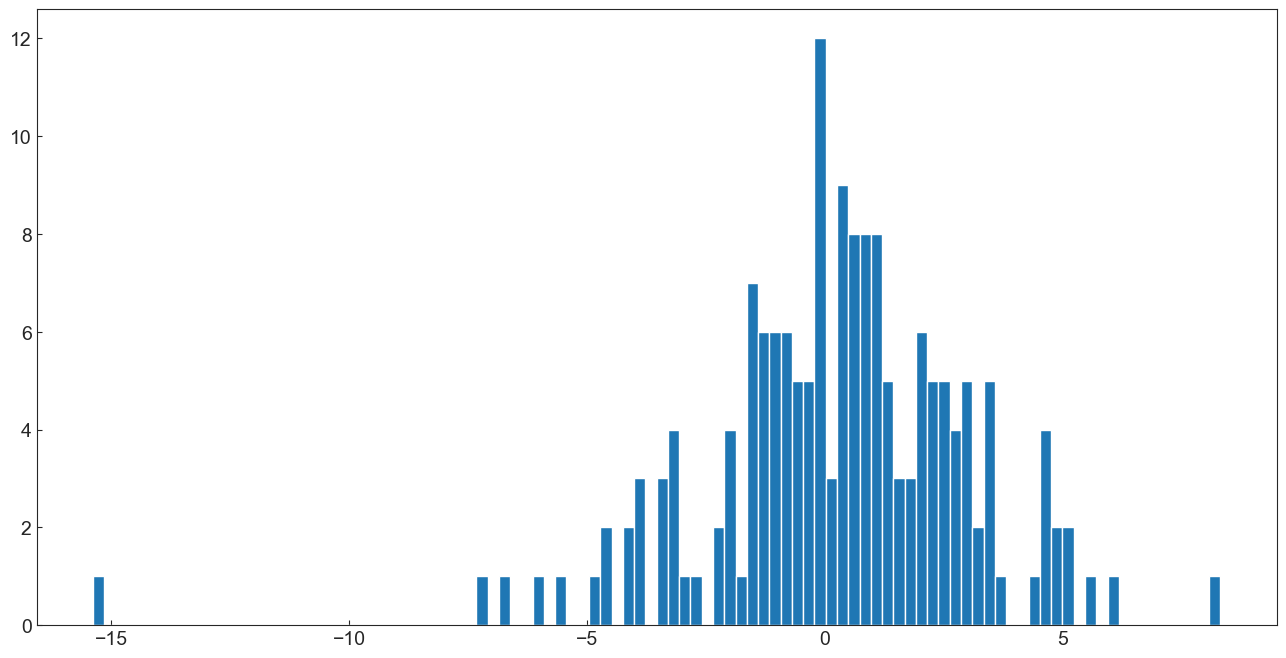

In [103]:
# Descriptive Statistics of the Strategies
fig, ax = plt.subplots()
ax.hist(df.Carry_G10, label="Carry G10", bins=100)
#ax.set_xbound(lower=0,upper=1)
plt.show()

# Train Test Split

In [104]:
data

,RF,avg_hours,infexp,initial_claims,YFFR10,building_permits,cons_sent,orders_CG,orders_cap,1_n_portfolio,leading_index,USSLIND
Date,,,,,,,,,,,,
2006-01-31,0.35,41.0,3.0,1622000,0.116000,2212,91.2,167243,58172,0.011327,1.84,1.84
2006-02-28,0.34,41.1,3.0,1263000,0.078421,2141,86.7,162922,59887,-0.001383,1.62,1.62
2006-03-31,0.37,41.1,3.0,1531000,0.130435,2118,88.9,165535,72879,0.007778,1.58,1.58
2006-04-30,0.36,41.2,3.3,1761000,0.222632,1998,87.4,165064,60704,0.005525,1.43,1.43
2006-05-31,0.43,41.2,4.0,1269000,0.178182,1905,79.1,169705,62738,-0.004814,1.08,1.08
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31,0.16,41.5,2.7,836000,-0.498636,1485,89.8,198267,64563,0.004684,1.31,1.31
2019-09-30,0.18,41.5,2.8,940000,-0.353000,1461,93.2,197802,68259,0.008448,1.50,1.50
2019-10-31,0.16,41.4,2.5,766000,-0.123182,1520,95.5,196395,65861,-0.003203,1.41,1.41


In [121]:
# Split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(data, strat_mtl, test_size=0.33, random_state=42, shuffle = False)
print("Test length is:", len(X_test))
print("Train length is:", len(X_train))
# at least 30 for regression I think
# ich glaube eifach 1-step a head prediction wär imfall au scho gnueg sprich "all except one" als trainset

Test length is: 56
Train length is: 112


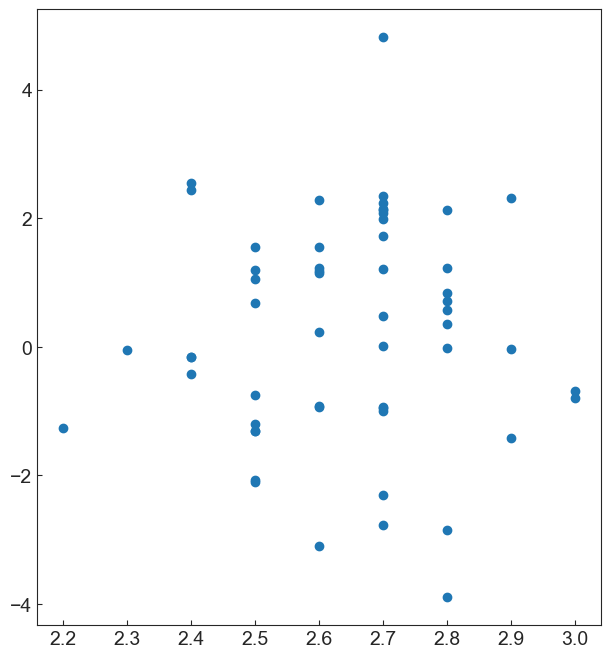

In [106]:
plt.subplot(122)
plt.scatter(X_test.infexp, y_test.Carry_G10)

# Predictive Regressions

In [107]:
# Durbin Watson Test
# H0 (null hypothesis): There is no correlation among the residuals.
# HA (alternative hypothesis): The residuals are autocorrelated.

In [108]:
len(y_train.Carry_G10)
len(X_train.infexp)
X_train.infexp.shape
y_train.Carry_G10.shape

(112,)

# Inflation Expectation Regressor

In [109]:
# Use rule of thumb to calculate number of lags taken into consideration for newey-west HAC and round up
print(0.75*len(X_train)**(1/3))

3.6152133962628445


## G10_Carry

In [110]:
# Regression using Newey West HAC standard errors because of the autocorrelation and heteroscedasticity

x = X_train.loc[:,["infexp"]]
y = y_train.loc[:, ["Carry_G10"]]

xt = X_test.loc[:,["infexp"]]
yt = y_test.loc[:, ["Carry_G10"]]


####### I would go with this approach in presence of autocorrelation in the errors ####### 
model1 = sm.OLS(endog=y, exog=sm.add_constant(x))
fit1 = model1.fit(cov_type="HAC",cov_kwds={"maxlags":4}) # Newey West SE with 4 lags
fit1.summary()
## --> Ich hätti so e regression gmacht mit dere cov_type"HAC" machsch newey west SE und d lags chasch mit de formle usrechne damits d autocorrelation guet userechnet
######################################################################################################

# SKLEARN WORKS BUT HAS NO ROBUST STANDARD ERRORS BUILT INTO ITS FIT() FUNCTION
model1 = LinearRegression().fit(x, y)
yt_pred = model1.predict(xt)
resid1 = yt - yt_pred
print("Durbin Watson test statistics is: ",durbin_watson(resid1), "must be between 1.5 and 2.5, else autocorrelation present") # H0: No correlation among residuals -> rejected if test is not between 1.5 and 2.5
print("The model score in sample is: ", model1.score(x, y, sample_weight=None)) # score uses R^2 and best is 1 and 0 means predicting same value always -> negative is shite
print("The model score out of sample is: ", model1.score(xt, yt, sample_weight=None))

Durbin Watson test statistics is:  [1.80333858] must be between 1.5 and 2.5, else autocorrelation present
The model score in sample is:  0.02331812219306273
The model score out of sample is:  -0.08380316156780498


## Carry_wEM

In [122]:
# Sklearn out of sample regression with R^2 as scorer
x = X_train.loc[:,["infexp"]]
y = y_train.loc[:, ["Carry_wEM"]]

xt = X_test.loc[:,["infexp"]]
yt = y_test.loc[:, ["Carry_wEM"]]

# SKLEARN WORKS BUT HAS NO ROBUST STANDARD ERRORS BUILT INTO ITS FIT() FUNCTION
model2 = LinearRegression().fit(x, y)
yt_pred = model2.predict(xt)
resid1 = yt - yt_pred
print("Durbin Watson test statistics is: ",durbin_watson(resid1), "must be between 1.5 and 2.5, else autocorrelation present") # H0: No correlation among residuals -> rejected if test is not between 1.5 and 2.5
print("The model score in sample is: ", model2.score(x, y, sample_weight=None)) # score uses R^2 and best is 1 and 0 means predicting same value always -> negative is shite
print("The model score out of sample is: ", model2.score(xt, yt, sample_weight=None))

Durbin Watson test statistics is:  [2.14878428] must be between 1.5 and 2.5, else autocorrelation present
The model score in sample is:  0.027971620005218356
The model score out of sample is:  -0.01775030006773859


## Long Duration

In [123]:
# Sklearn out of sample regression with R^2 as scorer
x = X_train.loc[:,["infexp"]]
y = y_train.loc[:, ["LongDuration"]]

xt = X_test.loc[:,["infexp"]]
yt = y_test.loc[:, ["LongDuration"]]

# SKLEARN WORKS BUT HAS NO ROBUST STANDARD ERRORS BUILT INTO ITS FIT() FUNCTION
model3 = LinearRegression().fit(x, y)
yt_pred = model3.predict(xt)
resid1 = yt - yt_pred
print("Durbin Watson test statistics is: ",durbin_watson(resid1), "must be between 1.5 and 2.5, else autocorrelation present") # H0: No correlation among residuals -> rejected if test is not between 1.5 and 2.5
print("The model score in sample is: ", model3.score(x, y, sample_weight=None)) # score uses R^2 and best is 1 and 0 means predicting same value always -> negative is shite
print("The model score out of sample is: ", model3.score(xt, yt, sample_weight=None))

Durbin Watson test statistics is:  [1.92846576] must be between 1.5 and 2.5, else autocorrelation present
The model score in sample is:  0.00040526917110061955
The model score out of sample is:  -0.016686461570597944


## Treasury Bonds

In [124]:
# Sklearn out of sample regression with R^2 as scorer
x = X_train.loc[:,["infexp"]]
y = y_train.loc[:, ["TreasuryBonds"]]

xt = X_test.loc[:,["infexp"]]
yt = y_test.loc[:, ["TreasuryBonds"]]

# SKLEARN WORKS BUT HAS NO ROBUST STANDARD ERRORS BUILT INTO ITS FIT() FUNCTION
model4 = LinearRegression().fit(x, y)
yt_pred = model4.predict(xt)
resid1 = yt - yt_pred
print("Durbin Watson test statistics is: ",durbin_watson(resid1), "must be between 1.5 and 2.5, else autocorrelation present") # H0: No correlation among residuals -> rejected if test is not between 1.5 and 2.5
print("The model score in sample is: ", model4.score(x, y, sample_weight=None)) # score uses R^2 and best is 1 and 0 means predicting same value always -> negative is shite
print("The model score out of sample is: ", model4.score(xt, yt, sample_weight=None))

Durbin Watson test statistics is:  [1.91402703] must be between 1.5 and 2.5, else autocorrelation present
The model score in sample is:  0.0004391129308581876
The model score out of sample is:  -0.042477139027145006


## TIPS

In [125]:
# Sklearn out of sample regression with R^2 as scorer
x = X_train.loc[:,["infexp"]]
y = y_train.loc[:, ["Tips"]]

xt = X_test.loc[:,["infexp"]]
yt = y_test.loc[:, ["Tips"]]

# SKLEARN WORKS BUT HAS NO ROBUST STANDARD ERRORS BUILT INTO ITS FIT() FUNCTION
model5 = LinearRegression().fit(x, y)
yt_pred = model5.predict(xt)
resid1 = yt - yt_pred
print("Durbin Watson test statistics is: ",durbin_watson(resid1), "must be between 1.5 and 2.5, else autocorrelation present") # H0: No correlation among residuals -> rejected if test is not between 1.5 and 2.5
print("The model score in sample is: ", model5.score(x, y, sample_weight=None)) # score uses R^2 and best is 1 and 0 means predicting same value always -> negative is shite
print("The model score out of sample is: ", model5.score(xt, yt, sample_weight=None))

Durbin Watson test statistics is:  [1.52943138] must be between 1.5 and 2.5, else autocorrelation present
The model score in sample is:  0.026428721275911338
The model score out of sample is:  -0.28244265110361844


# LEI Index as regressor

In [115]:
df

,RF,avg_hours,infexp,initial_claims,YFFR10,building_permits,cons_sent,orders_CG,orders_cap,1_n_portfolio,leading_index,USSLIND,Carry_wEM,Carry_G10,LongDuration,TreasuryBonds,Tips,ln_initial_claims,ln_orders_cap,ln_orders_CG
Date,,,,,,,,,,,,,,,,,,,,
2006-01-31,0.35,41.0,3.0,1622000,0.116000,2212,91.2,167243,58172,0.011327,1.84,1.84,0.477768,0.599041,-1.248434,-0.257327,-0.009412,14.299171,10.971159,12.027203
2006-02-28,0.34,41.1,3.0,1263000,0.078421,2141,86.7,162922,59887,-0.001383,1.62,1.62,0.907903,-0.781862,1.221589,0.078366,-0.047974,14.049000,11.000215,12.001027
2006-03-31,0.37,41.1,3.0,1531000,0.130435,2118,88.9,165535,72879,0.007778,1.58,1.58,-2.923076,-3.787657,-4.563440,-0.914071,-2.193861,14.241432,11.196556,12.016938
2006-04-30,0.36,41.2,3.3,1761000,0.222632,1998,87.4,165064,60704,0.005525,1.43,1.43,-1.077636,0.306145,-2.827478,-0.339877,-0.084525,14.381392,11.013765,12.014089
2006-05-31,0.43,41.2,4.0,1269000,0.178182,1905,79.1,169705,62738,-0.004814,1.08,1.08,-3.675135,-1.507144,0.127257,0.057776,0.294584,14.053740,11.046723,12.041817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31,0.16,41.5,2.7,836000,-0.498636,1485,89.8,198267,64563,0.004684,1.31,1.31,-1.336609,-0.991755,11.012873,3.401541,2.379862,13.636384,11.075397,12.197370
2019-09-30,0.18,41.5,2.8,940000,-0.353000,1461,93.2,197802,68259,0.008448,1.50,1.50,1.614866,1.220347,-2.644155,-0.858825,-1.361229,13.753635,11.131065,12.195022
2019-10-31,0.16,41.4,2.5,766000,-0.123182,1520,95.5,196395,65861,-0.003203,1.41,1.41,-1.182872,-0.754390,-1.100045,0.062318,0.255718,13.548937,11.095302,12.187883


## G10_Carry

In [126]:
# Regression using Newey West HAC standard errors because of the autocorrelation and heteroscedasticity

x = X_train.loc[:,["leading_index"]]
y = y_train.loc[:, ["Carry_G10"]]

xt = X_test.loc[:,["leading_index"]]
yt = y_test.loc[:, ["Carry_G10"]]


####### I would go with this approach in presence of autocorrelation in the errors ####### 
model6 = sm.OLS(endog=y, exog=sm.add_constant(x))
fit1 = model6.fit(cov_type="HAC",cov_kwds={"maxlags":4}) # Newey West SE with 4 lags
fit1.summary()
## --> Ich hätti so e regression gmacht mit dere cov_type"HAC" machsch newey west SE und d lags chasch mit de formle usrechne damits d autocorrelation guet userechnet
######################################################################################################

# SKLEARN WORKS BUT HAS NO ROBUST STANDARD ERRORS BUILT INTO ITS FIT() FUNCTION
model6 = LinearRegression().fit(x, y)
yt_pred = model6.predict(xt)
resid1 = yt - yt_pred
print("Durbin Watson test statistics is: ",durbin_watson(resid1), "must be between 1.5 and 2.5, else autocorrelation present") # H0: No correlation among residuals -> rejected if test is not between 1.5 and 2.5
print("The model score in sample is: ", model6.score(x, y, sample_weight=None)) # score uses R^2 and best is 1 and 0 means predicting same value always -> negative is shite
print("The model score out of sample is: ", model6.score(xt, yt, sample_weight=None))

Durbin Watson test statistics is:  [1.87440231] must be between 1.5 and 2.5, else autocorrelation present
The model score in sample is:  0.00353979945706695
The model score out of sample is:  -0.011769011847785782


# Cross Validation

In [118]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [119]:
btscv = BlockingTimeSeriesSplit(n_splits=5) # ob de shit funktioniert bini mer ned ganz sicher

In [132]:
scores = cross_val_score(model1, X_train, y_train, cv=btscv, scoring="r2") # Uses R2 as scorer -> see this docu for different scorers: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
scores
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))


-61.81 accuracy with a standard deviation of 67.51


# Under dem Markdown isch eig nur shit wo bim Code chönt helfe

# Help for Plots

In [117]:
# Object oriented plotting
df1['Date'] = df1['Date'].astype('datetime64[ns]')
fig, ax = plt.subplots()
ax.plot(df1.Date,df1.SARON, label="SARON-Fixings", color="grey")
ax.plot(df1.Date,df1.Segmented_regression, label="Segmented regression", color="black",linestyle='dashed')
ax.set_xlim([pd.to_datetime('2019-06-13 00:00:00'), pd.to_datetime('2019-12-11 00:00:00')])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.legend(loc="best")
ax.set_ylabel('SARON-Fixings')
plt.savefig("Graph_exports/ETC1_SegReg")

NameError: name 'df1' is not defined